In [1]:
!git clone https://github.com/susannapaoli/multimodal-memes.git

Cloning into 'multimodal-memes'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 528 (delta 157), reused 233 (delta 136), pack-reused 265
Receiving objects: 100% (528/528), 4.61 MiB | 3.37 MiB/s, done.
Resolving deltas: 100% (270/270), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import json

sys.path.append('/content/multimodal-memes/DEHATE_BERT')
sys.path.append('/content/multimodal-memes/Utils')
sys.path.append('/content/multimodal-memes/JSON Data')

from dataloader import mydataset 
from plot_curves import plot_loss, plot_acc
from unimodal_trainer import train, validation

'''
For DeHate
'''
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


**Upload data**

In [6]:
%cd /content/multimodal-memes/JSON Data

/content/multimodal-memes/JSON Data


In [7]:
#with open('train.jsonl', 'r') as f:
    #lines = f.readlines()

#split_idx = int(0.8*len(lines))
#train_lines = lines[:split_idx]
#val_lines = lines[split_idx:]

In [8]:
#with open('training.json', 'w') as f:
  #for line in lines[:split_idx]:
   # f.write(line)

#with open('validation.json', 'w') as f:
  #for line in lines[split_idx:]:
    #f.write(line)


In [9]:
trainlist = 'train.jsonl'
validlist = 'test_seen.jsonl'

In [10]:
train_dataset = mydataset(trainlist, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=16,pin_memory=True)
validation_dataset = mydataset(validlist, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 32, num_workers=16,pin_memory=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_m

**Model Definition**

In [11]:
model = BertForSequenceClassification.from_pretrained(
    "Hate-speech-CNERG/dehatebert-mono-english", 
    num_labels = 2, #Binary classification
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

#model = model.to(device)
model = nn.DataParallel(model).to(device)

**Hyperparameters**

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
num_Epochs = 10
total_steps = len(train_dataloader) * num_Epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,  num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
modelname = 'BERT_DeHate'
modelpath = './saved_model_checkpoints/'+modelname

In [14]:
writer = SummaryWriter(modelname)

train_loss, v_loss, v_acc = train(model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, modelpath, writer, device, epochs = num_Epochs)

writer.flush()
writer.close()

Epoch:  1
training loss =  0.5658238924535594
Validation Loss: 0.7909	Validation Accuracy: 0.5860
Epoch:  2
training loss =  0.5115795002171868
Validation Loss: 0.7600	Validation Accuracy: 0.6140
Epoch:  3
training loss =  0.4850644946546483
Validation Loss: 0.8158	Validation Accuracy: 0.6100
Epoch:  4
training loss =  0.45528097417121544
Validation Loss: 0.8908	Validation Accuracy: 0.5970
Epoch:  5
training loss =  0.4294399895278135
Validation Loss: 0.8514	Validation Accuracy: 0.5890
Epoch:  6
training loss =  0.41410091340093685
Validation Loss: 1.0086	Validation Accuracy: 0.5630
Epoch:  7
training loss =  0.39577424828719376
Validation Loss: 1.0106	Validation Accuracy: 0.5850
Epoch:  8
training loss =  0.3791767622071101
Validation Loss: 0.9155	Validation Accuracy: 0.5930
Epoch:  9
training loss =  0.36493488149087233
Validation Loss: 1.0146	Validation Accuracy: 0.5810
Epoch:  10
training loss =  0.35426704798425945
Validation Loss: 1.0278	Validation Accuracy: 0.5830


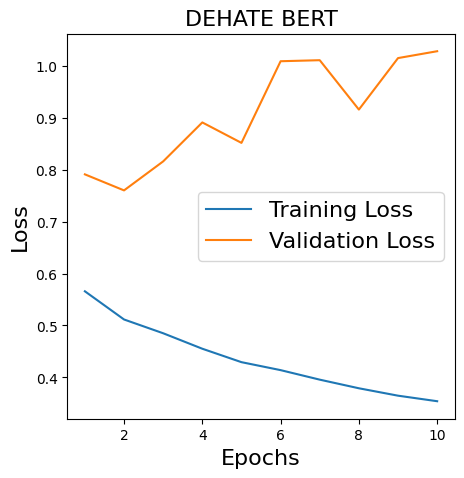

In [15]:
plot_loss(num_Epochs, train_loss, v_loss, 'DEHATE BERT')

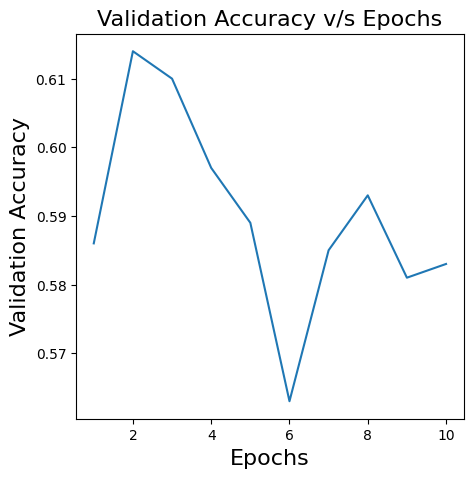

In [16]:
plot_acc(num_Epochs, v_acc)